In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [31]:
####################-1 Préparation et Chargement des Données en Python#################################

In [32]:
#chargement du fichier train.csvRemove-Item -Path "C:\Users\PC\Documents\.git" -Recurse -Force
df_train = pd.read_csv("C:/Users/PC/Documents/projet-immo/data/train.csv")
df_train.shape

(1460, 81)

In [33]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
#verifier wala identifier les valeur manquantes
missing_data = df_train.isnull().sum()
missing_percent = (missing_data / len(df_train)) * 100
missing_table = pd.concat([missing_data,missing_percent],axis=1, keys=['Total','pourcentage'])
missing_table = missing_table[missing_table['Total'] > 0]
print(missing_table.sort_values(by='pourcentage',ascending=False))

              Total  pourcentage
PoolQC         1453    99.520548
MiscFeature    1406    96.301370
Alley          1369    93.767123
Fence          1179    80.753425
MasVnrType      872    59.726027
FireplaceQu     690    47.260274
LotFrontage     259    17.739726
GarageType       81     5.547945
GarageYrBlt      81     5.547945
GarageFinish     81     5.547945
GarageQual       81     5.547945
GarageCond       81     5.547945
BsmtExposure     38     2.602740
BsmtFinType2     38     2.602740
BsmtQual         37     2.534247
BsmtCond         37     2.534247
BsmtFinType1     37     2.534247
MasVnrArea        8     0.547945
Electrical        1     0.068493


In [35]:
#Nettoyer les valeurs manquantes 
#premierement je vais supprimer tous les colonnes qui ont plus de 40% de NaN
col_supp = missing_table[missing_table['pourcentage'] > 40].index
df_clean = df_train.drop(columns=col_supp)

#je remplace les valeurs numeriques par leur median
col_numb = df_clean.select_dtypes(include=[np.number]).columns
for col in col_numb:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median)

#je remplace les valeurs categorielles par leur modes 
col_cat = df_clean.select_dtypes(include=['object']).columns 
for col in col_cat:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

print("Apres nettoyage : ", df_clean.shape)   

Apres nettoyage :  (1460, 75)


C:\Users\PC\AppData\Local\Temp\ipykernel_9244\2793447143.py:12: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  col_cat = df_clean.select_dtypes(include=['object']).columns


In [36]:
df_clean.isnull().sum().max()

np.int64(0)

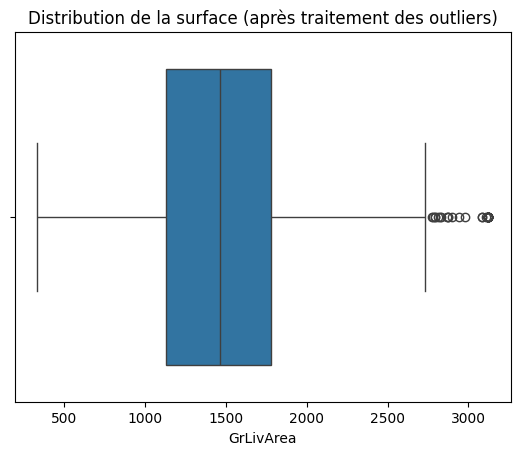

In [37]:
# Exemple sur la surface habitable (GrLivArea)
q_high = df_clean['GrLivArea'].quantile(0.99) # On prend le 99ème percentile
df_clean['GrLivArea'] = df_clean['GrLivArea'].clip(upper=q_high)

# Visualisation rapide
sns.boxplot(x=df_clean['GrLivArea'])
plt.title("Distribution de la surface (après traitement des outliers)")
plt.show()

In [38]:
#sauvegerder le fichier propre
df_clean.to_csv("df_train_clean.csv", index=False)
print("fichier save with succesfully")

fichier save with succesfully


In [39]:
#Creer la base de donnees avec sqlite3
import sqlite3

In [40]:
#charger le fichier csv
df_clean_s = pd.read_csv("df_train_clean.csv")

#connecter a la base de donnees
conn = sqlite3.connect("immobiliers_database.db")

#envoyer vers sql
df_clean_s.to_sql('housing_data',conn, if_exists='replace',index=False)

print("le fichier est integre avec succes!!")

le fichier est integre avec succes!!


In [41]:
#filtre le quartier oldtown
query = """
select *
from housing_data
where Neighborhood = 'OldTown'
"""
df_qrt = pd.read_sql_query(query, conn)
print(df_qrt)


       Id  MSSubClass MSZoning LotFrontage  LotArea Street LotShape  \
0       9          50       RM        51.0     6120   Pave      Reg   
1      49         190       RM        33.0     4456   Pave      Reg   
2      64          70       RM        50.0    10300   Pave      IR1   
3      69          30       RM        47.0     4608   Pave      Reg   
4      75          50       RM        60.0     5790   Pave      Reg   
..    ...         ...      ...         ...      ...    ...      ...   
108  1409          70       RM        60.0     7740   Pave      Reg   
109  1417         190       RM        60.0    11340   Pave      Reg   
110  1429          30       RM        60.0     7200   Pave      Reg   
111  1433          30       RL        60.0    10800   Pave      Reg   
112  1439          20       RM        90.0     7407   Pave      Reg   

    LandContour Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0           Lvl    AllPub    Inside  ...           205         0   

In [42]:
#requetes aggregations sur les insights par groupe
query_insight = """
    select avg(SalePrice) as prix_moyen, Neighborhood
    from housing_data
    group by Neighborhood
    order by prix_moyen desc
"""
df_insight = pd.read_sql_query(query_insight, conn)
print(df_insight)

       prix_moyen Neighborhood
0   335295.317073      NoRidge
1   316270.623377      NridgHt
2   310499.000000      StoneBr
3   242247.447368       Timber
4   238772.727273      Veenker
5   225379.837209      Somerst
6   212565.428571      ClearCr
7   210624.725490      Crawfor
8   197965.773333      CollgCr
9   194870.882353      Blmngtn
10  192854.506329      Gilbert
11  189050.068493       NWAmes
12  186555.796610      SawyerW
13  156270.122449      Mitchel
14  145847.080000        NAmes
15  142694.444444      NPkVill
16  142591.360000        SWISU
17  137500.000000      Blueste
18  136793.135135       Sawyer
19  128225.300885      OldTown
20  128219.700000      Edwards
21  124834.051724      BrkSide
22  104493.750000       BrDale
23  100123.783784       IDOTRR
24   98576.470588      MeadowV


In [43]:
########Analyse Exploratoire des Données (EDA) avec Python################

In [44]:
#recupere donnee yi si base bi
query_cor = """
select * 
from housing_data
"""
df_cor = pd.read_sql_query(query_cor, conn)

#on filtre que les colonnes numeriques
corr = df_cor.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)

print(corr.head(10))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.714002
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


In [45]:
#Visualisation 

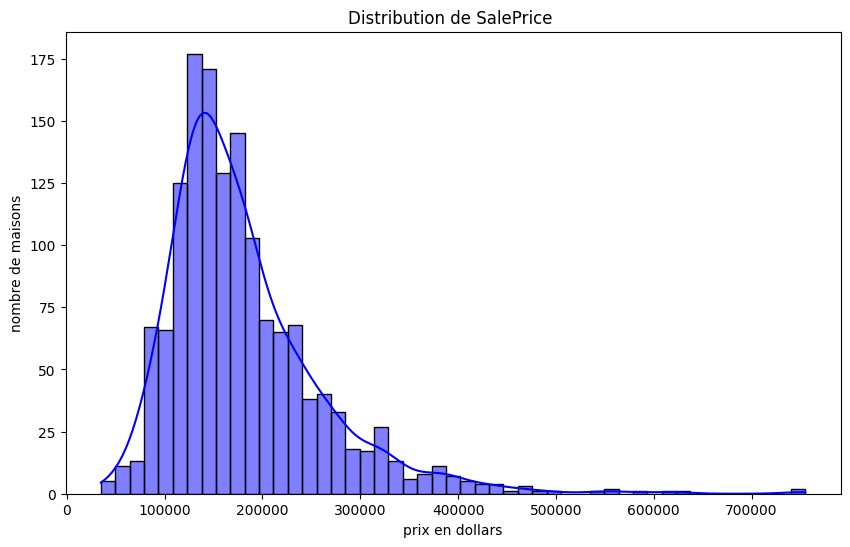

In [46]:
#histogramme pour la distribution de SalePrice
plt.figure(figsize=(10,6))
sns.histplot(df_cor['SalePrice'],kde=True,color='blue')
plt.title("Distribution de SalePrice ")
plt.xlabel("prix en dollars")
plt.ylabel("nombre de maisons")
plt.show()

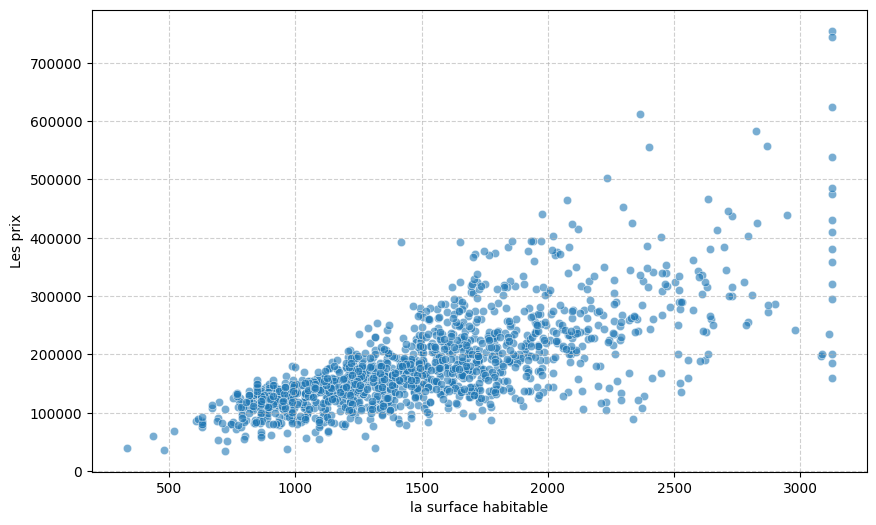

In [47]:
#Scatter plot pour la relation entre le prix(SalePrice) et la surface habitale(GrLivArea)
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_cor, x='GrLivArea',y='SalePrice',alpha=0.6)
plt.xlabel("la surface habitable")
plt.ylabel("Les prix")
plt.grid(True, linestyle='--',alpha=0.6)
plt.show()


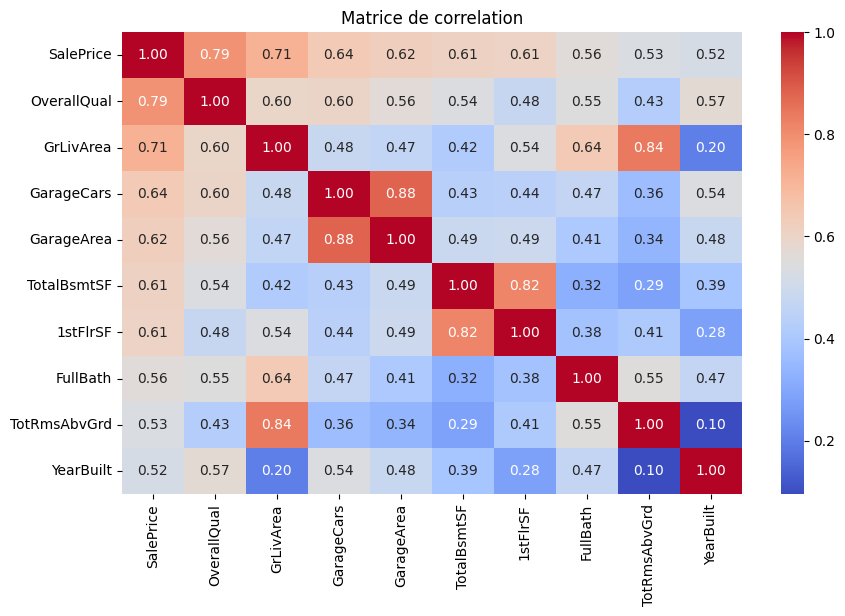

In [48]:
#Heatmap de correlation
plt.figure(figsize=(10,6))

#on prend les 10 premiers les plus correles
top_10 = corr.index[:10]
sns.heatmap(df_cor[top_10].corr(),annot=True,cmap='coolwarm', fmt='.2f')
plt.title("Matrice de correlation")
plt.show()

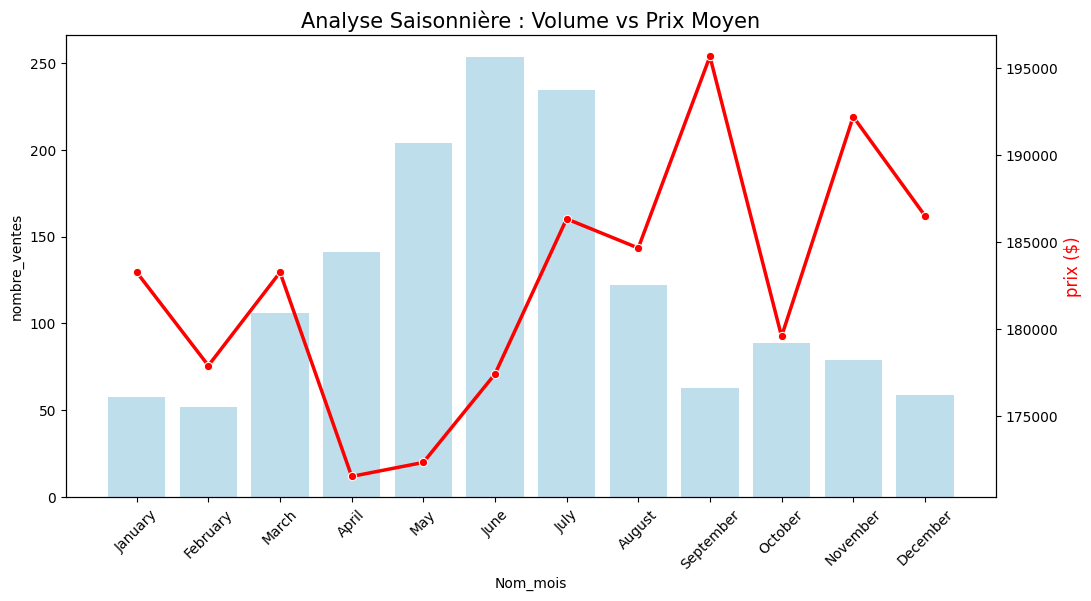

In [49]:
import calendar

#Voir la tendance saisonniere par mois 
query_mois = """
select MoSold as Mois , avg(SalePrice) as prix_moyen, count(*) as nombre_ventes
from housing_data
group by Mois
"""
df_mois = pd.read_sql_query(query_mois,conn)

#on remplace les numeros par le nom des mois
df_mois['Nom_mois'] = df_mois['Mois'].apply(lambda x : calendar.month_name[x])

#Graphique de visualisations
fig, ax1 = plt.subplots(figsize=(12,6))

#Graphique 1 volume des ventes
sns.barplot(x='Nom_mois',y='nombre_ventes',data=df_mois, ax=ax1, alpha=0.6, color='skyblue')
ax1.tick_params(axis='x',rotation=45)

#Creer un deuxieme grah
ax2 = ax1.twinx()

# Graphique 2 : Prix Moyen (Ligne)
sns.lineplot(x=range(len(df_mois)), y='prix_moyen', data=df_mois, ax=ax2, color='red', marker='o', linewidth=2.5)
ax2.set_ylabel('prix ($)', color='red', fontsize=12)

plt.title('Analyse Saisonnière : Volume vs Prix Moyen', fontsize=15)
plt.show()

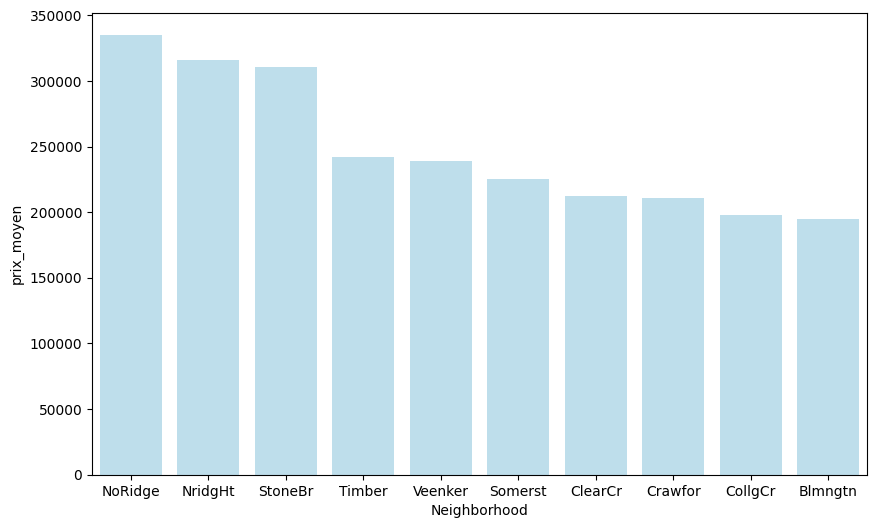

In [50]:
#Analyser les insghts les quartires qui ont le prix le plus eleve
plt.figure(figsize=(10,6))
sns.barplot(x='Neighborhood', y='prix_moyen', data=df_insight[:10], alpha=0.6, color='skyblue')
ax1.tick_params(axis='x',rotation=45)
plt.show()

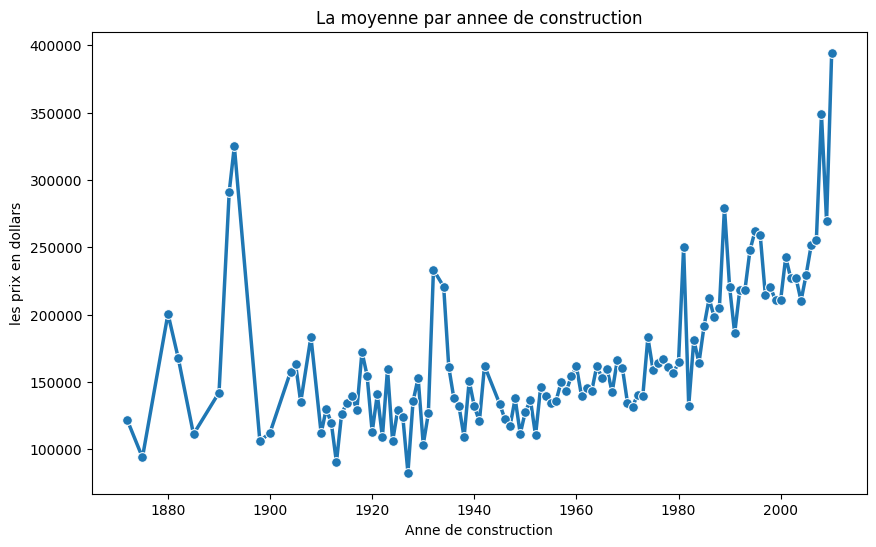

In [51]:
#query pour moyenne par année de construction.
query_cons = """
select YearBuilt   as Annee_cons, avg(SalePrice) as prix, count(*) as nombre
from housing_data
group by YearBuilt  
order by YearBuilt desc
"""
df_year = pd.read_sql_query(query_cons,conn)

plt.figure(figsize=(10,6))
sns.lineplot(x='Annee_cons', y = 'prix', data=df_year, linewidth=2.5, marker='o', markersize=7)
plt.xlabel('Anne de construction')
plt.ylabel('les prix en dollars')
plt.title("La moyenne par annee de construction")
plt.show()


In [52]:
################Modélisation avec Régression Linéaire et Scikit-Learn####################

In [53]:
df_clean.shape

(1460, 75)

In [54]:
import joblib
from sklearn.model_selection import train_test_split
from mon_outillage import pipeline_nettoyage_modele, cleaner_outlier, compare_modele


#Preparation des donnees
#1 extraire les donnees sur la base 
df_clean = pd.read_sql_query("select * from housing_data",conn)

#Appliquons ça aux valeurs critiques qui fausse le modele
col_crtiq = ['TotalBsmtSF', 'LotArea']
for col in col_crtiq:
    df_clean = cleaner_outlier(df_clean, col)
print("les outliers geres avec succes!!")

#3 separation des features
X = df_clean.drop(['SalePrice', 'Id'], axis=1)
y = df_clean['SalePrice']

#4split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#definir le pipeline de nettoyage
nettoyage = pipeline_nettoyage_modele(X_train)

#Lancement du tournoi
tableau_score = compare_modele(X_train, X_test, y_train, y_test, nettoyage)
print(tableau_score)

#on utilise le pipeline
mon_modele = pipeline_nettoyage_modele(X_train)

#Entrainement d'un coup 
mon_modele.fit(X_train,y_train)

#Prediction
y_pred = mon_modele.predict(X_test)

print(f"la dimension du train est : {X_train.shape}")

les outliers geres avec succes!!


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.980e+10, tolerance: 7.001e+08
  model = cd_fast.sparse_enet_coordinate_descent(


              modele  Score R2
3  gradient boosting  0.925696
0              ridge  0.909504
2      random forest  0.904732
1              lasso  0.866125
la dimension du train est : (1138, 73)


In [55]:
from sklearn.metrics import mean_squared_error, r2_score
#calcule mse et rmse
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)

#calcule r_score
r2 = r2_score(y_test,y_pred)
print(f"les score est : {r2:.4f}")

les score est : 0.9257


l'image enregistreavec succes


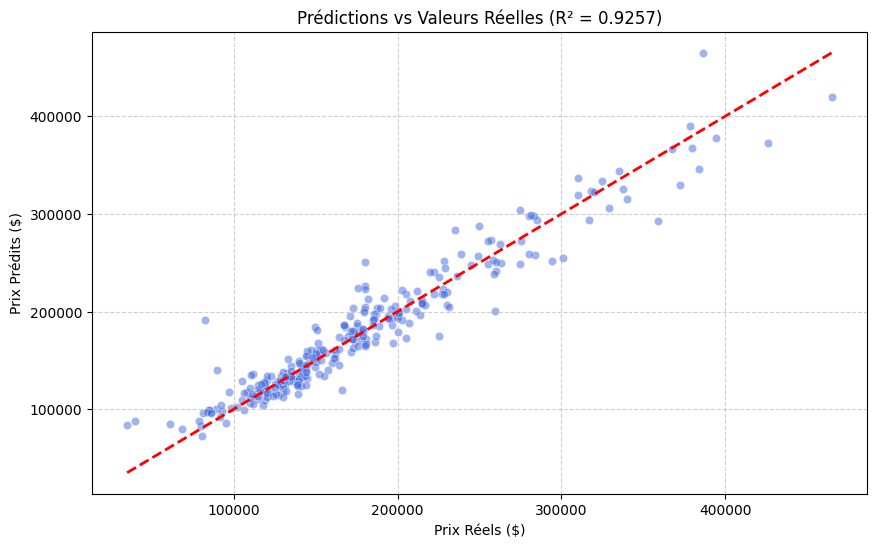

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
plt.figure(figsize=(10, 6))

# Création du scatter plot
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='royalblue')

# Ligne de perfection (où y_test == y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)

plt.title(f"Prédictions vs Valeurs Réelles (R² = {r2:.4f})")
plt.xlabel("Prix Réels ($)")
plt.ylabel("Prix Prédits ($)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('residu.png', dpi=300, bbox_inches='tight') 
print("l'image enregistreavec succes")
plt.show()




In [57]:
#Sauvegarde le modele et l'appliquons au test.csv
import joblib

#sauvegerde du modele ridge
joblib.dump(mon_modele, "mon_modele_gradient_final.pkl")

print("le modele et le scaler sauvegarder avec succes!!!")

le modele et le scaler sauvegarder avec succes!!!


In [58]:
#charger le modele pkl
mon_modele_charg = joblib.load("mon_modele_gradient_final.pkl")

#Charger les donnees test
df_test = pd.read_csv("C:/Users/PC/Documents/projet-immo/data/test.csv")


In [59]:
#ecartons le 'Id' pour le test final
test_id = df_test['Id']

#supprime le Id dans test
df_test_propre = df_test.drop('Id', axis=1)

#Predire les prix sur le fichier test
predire = mon_modele_charg.predict(df_test_propre)

#creer un dataframe pour voir les resultats
resultats = pd.DataFrame({
    'Id':test_id,
    'prix_predire':predire
})

print(resultats.head().round(2))

     Id  prix_predire
0  1461     127596.59
1  1462     165527.01
2  1463     179337.38
3  1464     182159.33
4  1465     199214.48


In [60]:
#sauvegarder
resultats.to_csv("resultat_grd_final.csv", index=False)
print("le fichier sauvegarder avec succes")

le fichier sauvegarder avec succes


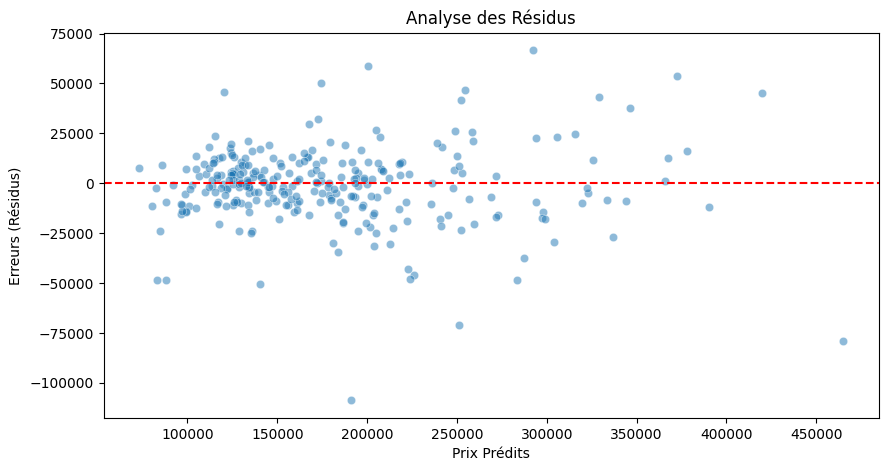

In [61]:
residus = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residus, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Analyse des Résidus")
plt.xlabel("Prix Prédits")
plt.ylabel("Erreurs (Résidus)")
plt.show()